# Test PCNetwork
Purpose: To do initial testing of the `PCNetwork` class.

In [886]:
import numpy as np
import matplotlib.pyplot as plt
import torch
%load_ext autoreload
%autoreload 1
%aimport PCNetwork
%aimport PCLayer
%aimport PCConnection

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [887]:
dtype = torch.float32
if torch.cuda.is_available():
    device = torch.device("cuda:0") # Uncomment this to run on GPU
else:
    device = torch.device("cpu")

# Dataset

In [979]:
# Make my own dataset
A = torch.tensor([[ 1.3874, -0.2003,  0.4514],
                  [-0.0967, -0.4015,  1.3332]], dtype=torch.float32, device=device)
n_classes, top_dim = np.shape(A)
B = torch.eye(n_classes, device=device)

print('Input vectors')
print(A)
print('Target vectors')
print(B)

Input vectors
tensor([[ 1.3874, -0.2003,  0.4514],
        [-0.0967, -0.4015,  1.3332]])
Target vectors
tensor([[1., 0.],
        [0., 1.]])


In [964]:
# Make my own dataset
A = torch.tensor([[1, 0],[0,1]], dtype=torch.float32, device=device)
n_classes, top_dim = np.shape(A)
B = torch.eye(n_classes, device=device)

print('Input vectors')
print(A)
print('Target vectors')
print(B)

Input vectors
tensor([[1., 0.],
        [0., 1.]])
Target vectors
tensor([[1., 0.],
        [0., 1.]])


# Create Network

In [980]:
net = PCNetwork.PCNetwork()

net.AddLayer(PCLayer.PCLayer(n=top_dim))  # v0 (input layer)
net.AddLayer(PCLayer.PCLayer(n=2))  # / e1
net.AddLayer(PCLayer.PCLayer(n=2))  # \ v1 (output layer)

net.lyr[1].SetDecay(1.)  # decay rate for error nodes
net.Connect(v_idx=0, e_idx=1, type='general', sym=True, act_text='identity')
net.Connect(e_idx=1, v_idx=2, type='1to1')

net.SetTau(0.05)
net.Learning(True)

In [981]:
#net.con[0].SetIdentity()
#net.con[1].SetIdentity()

In [982]:
#net.Save('my.net')
#net2 = PCNetwork.PCNetwork.Load('my.net')

# Test

In [983]:
net.lyr[0].Probe(True)
net.lyr[1].Probe(True)
net.lyr[2].Probe(True)

In [984]:
net.con[0].M

tensor([[-0.8187,  0.3254],
        [-1.1145,  0.0087],
        [ 0.4345, -0.2159]])

In [985]:
net.Predict(A, T=4.)

tensor([[-0.7165,  0.3522],
        [ 1.1059, -0.3227]])

In [991]:
np.array(net.lyr[0].x_history).shape

(4001, 2, 3)

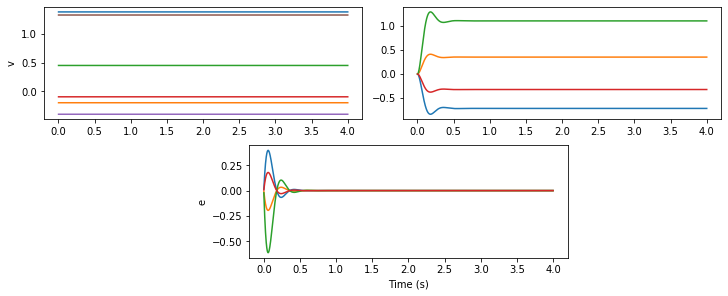

In [994]:
net.Plot(idx=[0,1]);

In [995]:
net.Learn(A, B, T=4., epochs=5, batchsize=2)

Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4


In [996]:
net.Reset()
net.Predict(A, T=4.)

tensor([[1.0000e+00, 2.6822e-07],
        [9.5368e-07, 1.0000e+00]])

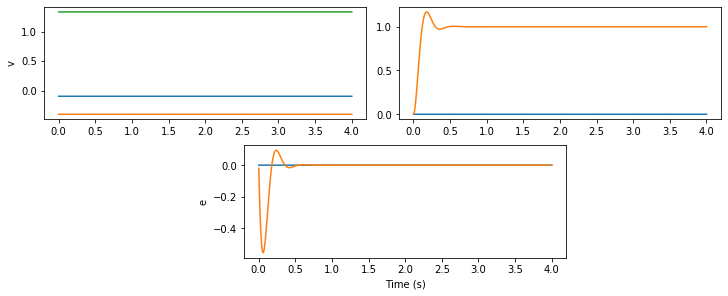

In [998]:
fig = net.Plot(idx=[1])